In [205]:
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb #############
import lightgbm as lgb#############
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_datareader.data as web

from matplotlib import style
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import warnings
warnings.filterwarnings("ignore")

In [161]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("AAPL", "yahoo", start, end)
print(df.head())
print()
print(df.shape)

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2010-01-04  30.642857  30.340000  30.490000  30.572857  123432400.0  26.681330
2010-01-05  30.798571  30.464285  30.657143  30.625713  150476200.0  26.727465
2010-01-06  30.747143  30.107143  30.625713  30.138571  138040000.0  26.302330
2010-01-07  30.285715  29.864286  30.250000  30.082857  119282800.0  26.253704
2010-01-08  30.285715  29.865715  30.042856  30.282858  111902700.0  26.428249

(2432, 6)


## Calculate various moving averages

In [162]:
close_px = df["Adj Close"]
movavg_50 = close_px.rolling(window=50).mean()
movavg_100 = close_px.rolling(window=100).mean()
movavg_200 = close_px.rolling(window=200).mean()

### Plot moving averages compared to each other and the closing prices

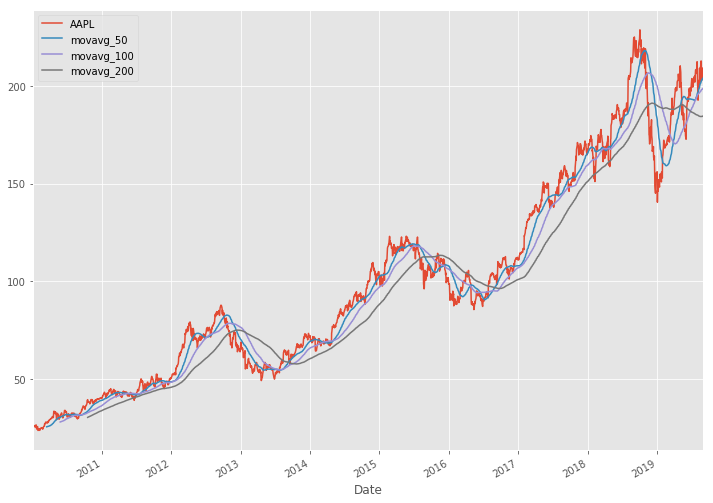

In [163]:
# Adjusting the size of the plot
mpl.rc("figure", figsize=(12, 9))
mpl.__version__

# Adjusting the style of the plot
style.use("ggplot")
close_px.plot(label="AAPL")
movavg_50.plot(label="movavg_50")
movavg_100.plot(label="movavg_100")
movavg_200.plot(label="movavg_200")
plt.legend()

### Return Deviation - to determine risk and return

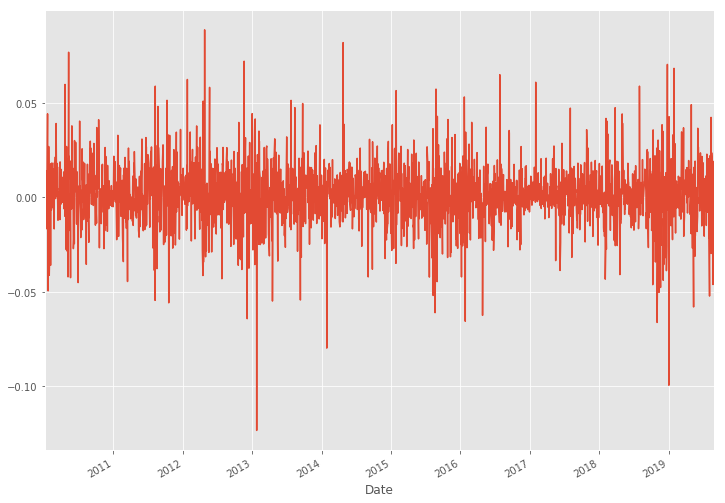

In [164]:
# Return = (closing_price / closing_price_last_day) - 1
returns = close_px / close_px.shift(1) - 1

returns.plot(label="return")

## Analysing the competitors stocks

In [165]:
df_competitors = web.DataReader(["AAPL", "GE", "GOOG", "IBM", "MSFT"], "yahoo", start=start, end=end)["Adj Close"]

In [166]:
print(df_competitors.head())
print(df_competitors.tail())

Symbols          AAPL         GE        GOOG        IBM       MSFT
Date                                                              
2010-01-04  26.681330  10.906911  312.204773  98.142967  24.443624
2010-01-05  26.727465  10.963388  310.829926  96.957375  24.451517
2010-01-06  26.302330  10.906911  302.994293  96.327530  24.301458
2010-01-07  26.253704  11.471671  295.940735  95.994110  24.048725
2010-01-08  26.428249  11.718755  299.885956  96.957375  24.214581
Symbols           AAPL    GE         GOOG         IBM        MSFT
Date                                                             
2019-08-26  206.490005  8.05  1168.890015  129.990005  135.449997
2019-08-27  204.160004  7.93  1167.839966  131.169998  135.740005
2019-08-28  205.529999  7.94  1171.020020  132.759995  135.559998
2019-08-29  209.009995  8.11  1192.849976  134.880005  138.119995
2019-08-30  208.740005  8.25  1188.099976  135.529999  137.860001


### Correlation Analysis - Does one competitor affect others?

In [167]:
returns_competitors = df_competitors.pct_change()

corr = returns_competitors.corr()

corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.321165,0.462883,0.385814,0.457645
GE,0.321165,1.000000,0.332437,0.437855,0.361893
GOOG,0.462883,0.332437,1.000000,0.406329,0.538604
IBM,0.385814,0.437855,0.406329,1.000000,0.491927
MSFT,0.457645,0.361893,0.538604,0.491927,1.000000


Text(0, 0.5, 'Return GE')

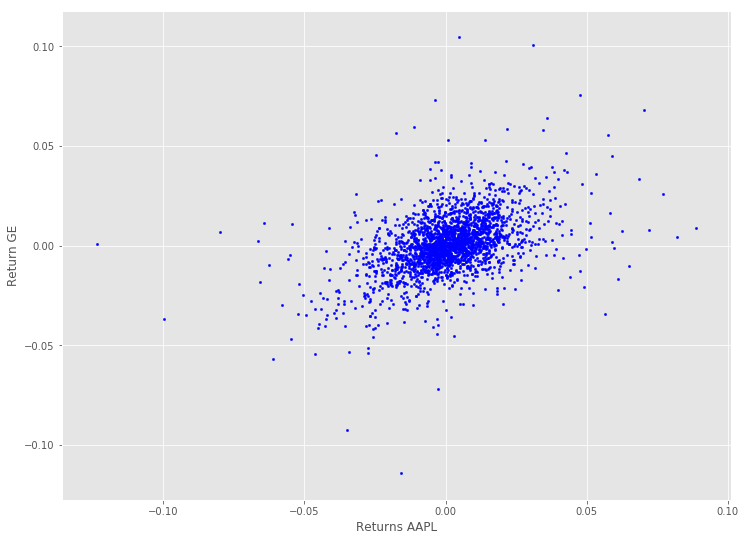

In [168]:
# plot the correlation of apple and microsoft
plt.scatter(returns_competitors.AAPL, returns_competitors.MSFT, color="blue", s=5)
plt.xlabel("Returns AAPL")
plt.ylabel("Return GE")

In [169]:
# plot a scatter matrix to visualize all correlations

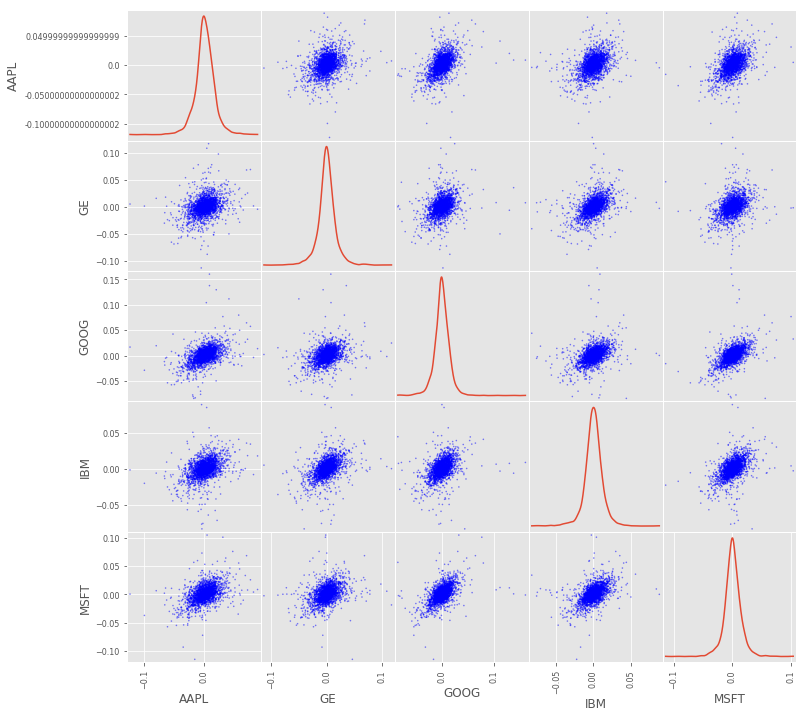

In [170]:
pd.plotting.scatter_matrix(returns_competitors, diagonal="kde", figsize=(12, 12), s=10, color="blue");

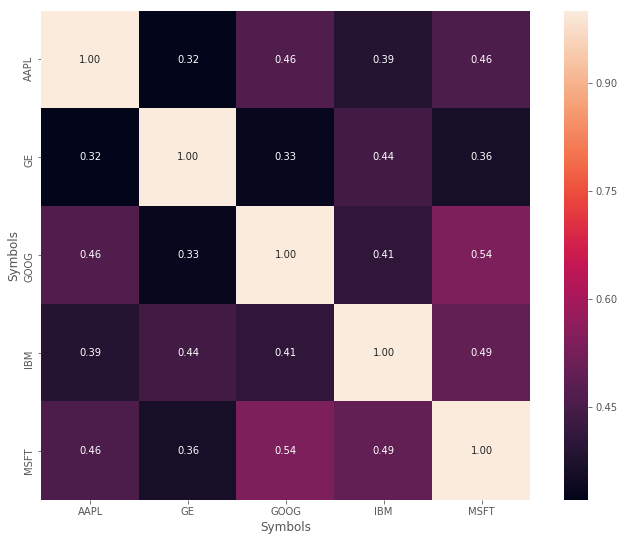

In [171]:
heatmap = sns.heatmap(corr, cbar=True, annot=True, fmt=".2f", annot_kws={"size": 10},
                     square=True, yticklabels=corr.columns, xticklabels=corr.columns)

## Stocks Returns Rate and Risk

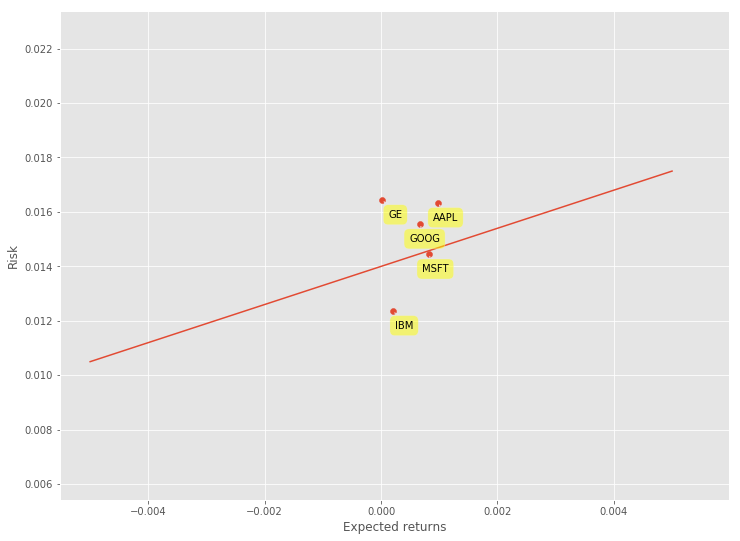

In [172]:
plt.scatter(returns_competitors.mean(), returns_competitors.std())
plt.xlabel("Expected returns")
plt.ylabel("Risk")

for label, x, y in zip(returns_competitors.columns, returns_competitors.mean(), returns_competitors.std()):
    plt.annotate(label, xy = (x, y), xytext = (20, -20), textcoords = 'offset points', ha = 'right',
                 va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                 arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

x = np.linspace(-0.005, 0.005, 100)
plt.plot(x, 0.7*x + 0.014, linestyle="solid")

#### sell stocks above red line and buy stocks below

# Predictings Stock Prices
## Feature Engineering

In [173]:
df_lr = df.loc[:, ["Adj Close", "Volume"]]
df_lr["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
df_lr["PCT_Change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

df_lr.head()

,Adj Close,Volume,HL_PCT,PCT_Change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


## Pre-processing & Cross validation

1. Drop misssing values
2. Separte the label here, we only want to predict the AdjClose
3. Scale the X so that everyone can habe the same distribution for linear regression
4. Finally you want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Sepation of training and testing of model by cross validation train test split

In [174]:
# 1.
df_lr.fillna(value=-99999, inplace=True)

# separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df_lr)))

# 2.
forecast_column = "Adj Close"
df_lr["label"] = df_lr[forecast_column].shift(-forecast_out)
X = np.array(df_lr.drop(["label"], 1))

# 3.
X = preprocessing.scale(X)

# 4.
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# 5.
y = np.array(df_lr["label"])
y = y[:-forecast_out]


In [175]:
# separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Generation

## Simple Linear Analysis & Quadratic Discriminant Analysis

In [176]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
    return(rmse)

In [193]:
# # Linear Regression
# lr_clf = LinearRegression(n_jobs=-1)
# lr_clf.fit(X_train, y_train)

# # Quadratic Regression 2
# quad_clf = make_pipeline(PolynomialFeatures(2), Ridge())
# quad_clf.fit(X_train, y_train)

# # Quadratic Regression 3
# qubic_clf = make_pipeline(PolynomialFeatures(3), Ridge())
# qubic_clf.fit(X_train, y_train)

Best alpha:  1
Ridge Score on Training Set:  0.9626373329712254


RidgeCV(alphas=array([1]), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

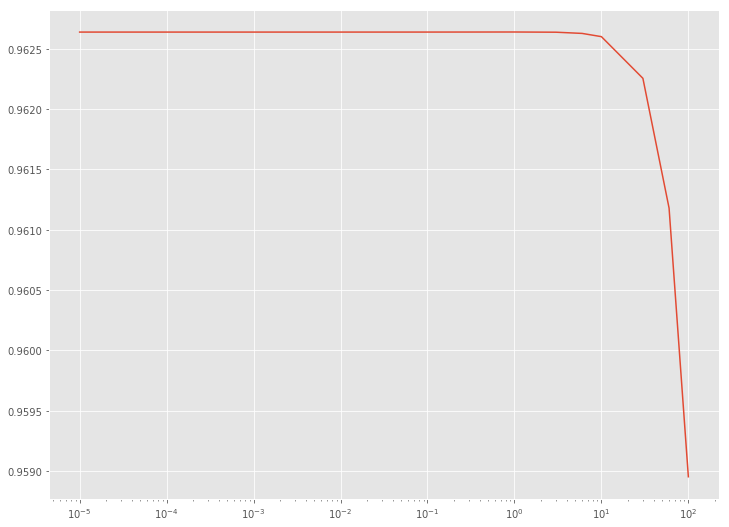

In [194]:
l1 = [0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100]
l2 = [2, 3, 4, 5, 6, 7, 8, 9, 10]

best_score = 0
best_alpha = 0
scores = []

for i in l1:
    ridge = RidgeCV(alphas=[i])
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_alpha = ridge.alpha_

plt.plot(l1, scores)
plt.xscale("log")

print("Best alpha: ", best_alpha)
print("Ridge Score on Training Set: ", best_score)

ridge = RidgeCV(alphas=[best_alpha])
ridge.fit(X_train, y_train)

Best alpha:  0.1
Lasso Score on Test Set:  0.9626432823938962


LassoCV(alphas=[0.1], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

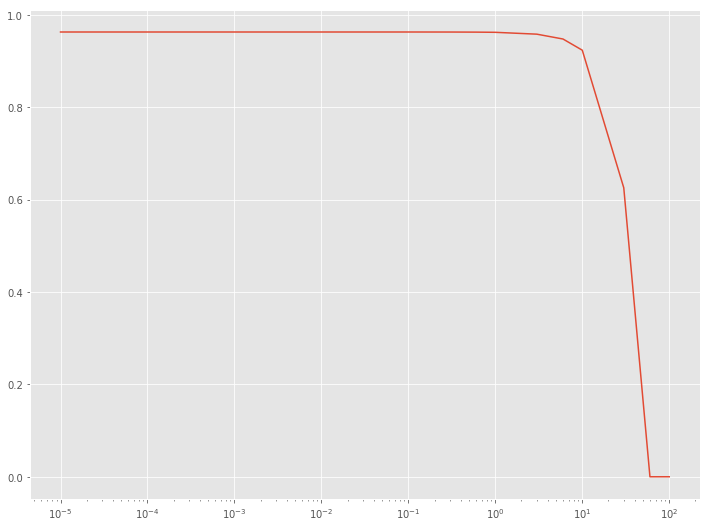

In [195]:
best_score = 0
best_alpha = 0
scores = []

for i in l1:
    lasso = LassoCV(alphas=[i], cv=5)
    lasso.fit(X_train, y_train)
    score = lasso.score(X_test, y_test)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_alpha = lasso.alpha_

plt.plot(l1, scores)
plt.xscale("log")

print("Best alpha: ", best_alpha)
print("Lasso Score on Test Set: ", best_score)

lasso = LassoCV(alphas=[best_alpha], cv=5)
lasso.fit(X_train, y_train)

In [199]:
best_score = 0
best_alpha = 0
best_cv = 0
best_l1_ratio = 0

scores = []

for j in l2:
    best_score = 0
    best_alpha = 0
    scores = []
    for i in l1:
        for k in [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]:
            elasticNet = ElasticNetCV(l1_ratio=[k], alphas=[i], cv=j)
            elasticNet.fit(X_train, y_train)
            score = elasticNet.score(X_test, y_test)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_alpha = i
                best_cv = j
                best_l1_ratio = k
#     print("Best alpha: ", best_alpha)
#     print("Ridge Score on Training Set: ", best_score)
#     print("Best CV: " + str(best_cv))
#     plt.plot(l1, scores)
#     plt.xscale("log")
#     plt.show()

    
print("Best alpha: ", best_alpha)
print("Elastic Net CV Score on Test Set: ", best_score)
print("Best CV: " + str(best_cv))
print("Best L1 Ratio: " + str(best_l1_ratio))

# plt.plot(l1, scores)
# plt.xscale("log")

elasticNet = ElasticNetCV(l1_ratio=[best_l1_ratio], alphas=[best_alpha], cv=best_cv)
elasticNet.fit(X_train, y_train)

Best alpha:  0.1
Elastic Net CV Score on Test Set:  0.9626432823938962
Best CV: 10
Best L1 Ratio: 1


ElasticNetCV(alphas=[0.1], copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[1], max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [200]:
best_score = 0
best_alpha = 0
best_coef0 = 0
best_degree = 0

scores = []
rounds_completed = 1

for j in [2, 3, 4]:
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        for i in l1:
            krr = KernelRidge(alpha=[i], kernel="polynomial", degree=j, coef0=k)
            krr.fit(X_train, y_train)
            score = krr.score(X_test, y_test)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_alpha = i
                best_degree = j
                best_coef0 = k
    print("Round " + str(rounds_completed) + " completed!")
    rounds_completed += 1

print("Best alpha: " + str(best_alpha))
print("Kernel Ridge Score on Test Set: ", best_score)
print("Best degree: " + str(best_degree))
print("Best coef0: " + str(best_coef0))

krr = KernelRidge(alpha=[best_alpha], kernel="polynomial", degree=best_degree, coef0=best_coef0)
krr.fit(X_train, y_train)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Best alpha: 3
Kernel Ridge Score on Test Set:  0.9688424130109656
Best degree: 3
Best coef0: 1


KernelRidge(alpha=[3], coef0=1, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None)

In [201]:
best_score = 0
best_n_estimators = 0
best_learning_rate = 0

scores = []
rounds_completed = 1
for j in [50, 100, 250, 500, 1000, 2500]:
    for k in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        GBoost = GradientBoostingRegressor(n_estimators=j, learning_rate=k,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=2, 
                                   loss='huber', random_state=5)
        GBoost.fit(X_train, y_train)
        score = GBoost.score(X_test, y_test)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_n_estimators = j
            best_learning_rate = k
    print("Round " + str(rounds_completed) + " completed")
    rounds_completed += 1
    
print("Gradient Boosting Score on Test Set: ", best_score)
print("Best degree: " + str(best_learning_rate))
print("Best coef0: " + str(best_n_estimators))

GBoost = GradientBoostingRegressor(n_estimators=best_n_estimators, learning_rate=best_learning_rate,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=2, 
                                   loss='huber', random_state=5)
GBoost.fit(X_train, y_train)

Round 1 completed
Round 2 completed
Round 3 completed
Round 4 completed
Round 5 completed
Round 6 completed
Gradient Boosting Score on Test Set:  0.9734209990878164
Best degree: 0.01
Best coef0: 500


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

## KNearestNeighbors Regression

In [208]:
best_score = 0
best_n_neighbors = 0
scores = []

for i in [1, 2, 3, 4, 5, 7, 9]:
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_n_neighbors = i

print("Best number of neighbors: ", best_n_neighbors)
print("K Nearest Neighbors Score on Training Set: ", best_score)

knn = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best number of neighbors:  5
K Nearest Neighbors Score on Training Set:  0.95952124840864


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

## Average Models to get better results

In [209]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones of ther original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # train all cloned models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    # predictions for cloned models
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [218]:
# Models available: LinearRegression, RidgeCV, LassoCV, ElasticNet, KernelRidgeRegression, GradientBoostingRegressor, KNearestNeighbors Regression
averaged_models_1 = AveragingModels(models=(ridge, lasso, krr, GBoost, knn))
averaged_models_1.fit(X_train, y_train)
print(averaged_models_1.score(X_test, y_test))

averaged_models_2 = AveragingModels(models=(ridge, lasso, krr, GBoost))
averaged_models_2.fit(X_train, y_train)
print(averaged_models_2.score(X_test, y_test))

averaged_models_3 = AveragingModels(models=(ridge, lasso, krr, knn))
averaged_models_3.fit(X_train, y_train)
print(averaged_models_3.score(X_test, y_test))

averaged_models_4 = AveragingModels(models=(ridge, lasso, GBoost, knn))
averaged_models_4.fit(X_train, y_train)
print(averaged_models_4.score(X_test, y_test))

averaged_models_5 = AveragingModels(models=(ridge, krr, GBoost, knn))
averaged_models_5.fit(X_train, y_train)
print(averaged_models_5.score(X_test, y_test))

averaged_models_6 = AveragingModels(models=(lasso, krr, GBoost, knn))
averaged_models_6.fit(X_train, y_train)
print(averaged_models_6.score(X_test, y_test))

averaged_models_7 = AveragingModels(models=(ridge, lasso, krr))
averaged_models_7.fit(X_train, y_train)
print(averaged_models_7.score(X_test, y_test))

averaged_models_8 = AveragingModels(models=(ridge, lasso, knn))
averaged_models_8.fit(X_train, y_train)
print(averaged_models_8.score(X_test, y_test))

averaged_models_9 = AveragingModels(models=(ridge, lasso, GBoost))
averaged_models_9.fit(X_train, y_train)
print(averaged_models_9.score(X_test, y_test))

averaged_models_10 = AveragingModels(models=(krr, GBoost, knn))
averaged_models_10.fit(X_train, y_train)
print(averaged_models_10.score(X_test, y_test))

0.9696122707793858
0.9686266102409828
0.9676430680921609
0.9693082003097409
0.9705831415496565
0.970588078827864
0.965266703489923
0.9665377926504006
0.9681409755981816
0.9715246775595101


#### Result: Averaged models are not better than the Gradient Boosting Regressor alone

## Evaluation

In [222]:
# lr_score = lr_clf.score(X_test, y_test)
# quad_score = quad_clf.score(X_test, y_test)
# qubic_score = qubic_clf.score(X_test, y_test)
# knn_score = knn_clf.score(X_test, y_test)

# # Results
# print("The Linear Regression accuracy is " + str(lr_score))
# print("The Quadratic Regression accuracy is " + str(quad_score))
# print("The Qubic Regression accuracy is " + str(qubic_score))
# print("The KNearestNeighbors Regression accuracy is " + str(knn_score))

## Some Stock Forecasting

In [223]:
forecast_set = GBoost.predict(X_lately)
df_lr["Forecast"] = np.nan

# Results
print(forecast_set, qubic_score, forecast_out)

[202.48763145 196.20982828 184.9819991  181.51681485 191.50683995
 178.50622295 193.96820046 189.95547724 192.2988959  196.66819756
 199.04480133 193.93062419 191.13221259 194.99365135 198.38789282
 201.35319484 201.27480325 200.38381894 202.76396528 179.24163434
 199.08763923 197.13407026 210.63645667 204.28165802 201.89819091] 0.9725605655909576 25


# Plotting the Prediction

In [224]:
last_data = df_lr.iloc[-1].name
last_unix = last_data
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df_lr.loc[next_date] = [np.nan for _ in range(len(df_lr.columns) - 1)] + [i]

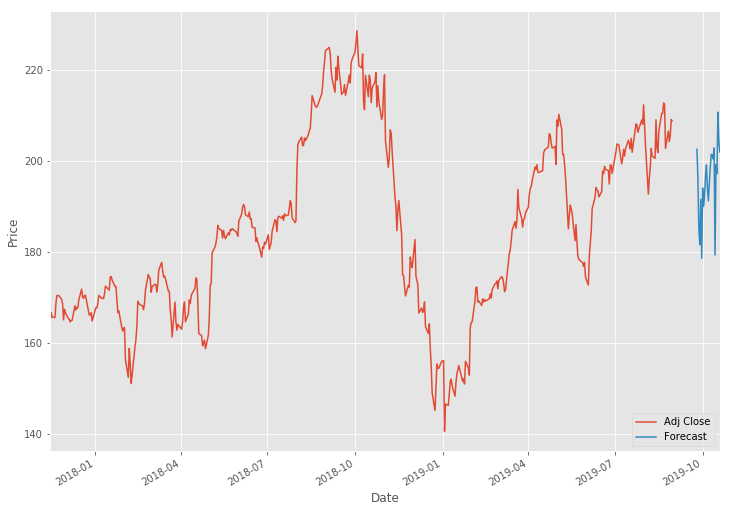

In [227]:
df_lr["Adj Close"].tail(500).plot()
df_lr["Forecast"].tail(500).plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()